In [1]:
# ==============================================================================
# CELL 1: SETUP AND IMPORTS
# ==============================================================================
import os
import shutil
import random
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time # <-- ADD THIS

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torch.optim.lr_scheduler import CosineAnnealingLR

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
# --- ADD THESE IMPORTS for ROC/AUC ---
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from scipy.special import softmax
import tensorflow as tf # <-- ADD THIS
# ------------------------------------
seed_value = 42

# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
os.environ['PYTHONHASHSEED'] = str(seed_value)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
random.seed(seed_value)

# 3. Set the `numpy` pseudo-random generator at a fixed value
np.random.seed(seed_value)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
tf.random.set_seed(seed_value)
import kagglehub

print("All libraries imported successfully.")

2025-08-28 19:38:00.092476: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756409880.290067      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756409880.356326      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


All libraries imported successfully.


In [2]:
# ==============================================================================
# CELL 2: DOWNLOAD AND PREPARE DATASET
# ==============================================================================
# --- Download from Kaggle ---
print("Downloading dataset from Kaggle Hub...")
path = kagglehub.dataset_download("mrnotalent/braint")
print(f"Path to dataset files: {path}")

# --- Copy to a writable directory ---
# This is necessary as the Kaggle input directory is read-only
src = path
dst = '/content/braint_original'
shutil.copytree(src, dst, dirs_exist_ok=True)
print(f"Dataset copied to {dst}")

Path to dataset files: /kaggle/input/
Dataset copied to /content/braint_original


In [3]:
# ==============================================================================
# CELL 3: CREATE TRAIN / VALIDATION / TEST SPLIT
# ==============================================================================
# --- Step A: Define paths and create the new directory structure ---
original_base_dir = '/kaggle/input/'
new_base_dir = '/content/data'

class_names = [d for d in os.listdir(original_base_dir) if os.path.isdir(os.path.join(original_base_dir, d))]
print(f"Found {len(class_names)} classes: {class_names[:5]}...") # Print first 5 classes

# Create train/val/test directories
for split in ['train', 'val', 'test']:
    for class_name in class_names:
        os.makedirs(os.path.join(new_base_dir, split, class_name), exist_ok=True)

# --- Step B: Gather all file paths and labels ---
all_files = []
for class_name in class_names:
    class_dir = os.path.join(original_base_dir, class_name)
    for fname in os.listdir(class_dir):
        if os.path.isfile(os.path.join(class_dir, fname)):
            all_files.append({'path': os.path.join(class_dir, fname), 'label': class_name})

df = pd.DataFrame(all_files)

# --- Step C: Stratified split into train, validation, and test sets ---
train_df, temp_df = train_test_split(df, test_size=0.30, random_state=42, stratify=df['label'])
val_df, test_df = train_test_split(temp_df, test_size=0.50, random_state=42, stratify=temp_df['label'])

print(f"\nTotal images: {len(df)}")
print(f"Training size: {len(train_df)} (70%)")
print(f"Validation size: {len(val_df)} (15%)")
print(f"Test size: {len(test_df)} (15%)")

# --- Step D: Copy files into the new directories ---
def copy_files(dataframe, split_name):
    for _, row in dataframe.iterrows():
        src_path = row['path']
        dst_path = os.path.join(new_base_dir, split_name, row['label'], os.path.basename(src_path))
        shutil.copy(src_path, dst_path)
    print(f"Finished copying {split_name} files.")

copy_files(train_df, 'train')
copy_files(val_df, 'val')
copy_files(test_df, 'test')
print("\nData splitting and structuring complete.")

Found 44 classes: ['Papiloma T2', 'Tuberculoma T1C+', 'Granuloma T1', 'Carcinoma T2', '_NORMAL T1']...

Total images: 16236
Training size: 11365 (70%)
Validation size: 2435 (15%)
Test size: 2436 (15%)
Finished copying train files.
Finished copying val files.
Finished copying test files.

Data splitting and structuring complete.


In [4]:
# ==============================================================================
# CELL 4: DEFINE TRANSFORMS AND DATALOADERS
# ==============================================================================
IMG_SIZE = 224

# --- Define conservative medical image augmentations ---
train_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5), # Flipping is often a useful augmentation
    transforms.RandomRotation(degrees=15),   # Slightly increase rotation
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)), # Added Affine
    transforms.ToTensor(),
    transforms.Lambda(lambda t: t.expand(3, -1, -1) if t.shape[0]==1 else t),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.2)), # Added Random Erasing
])

val_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Lambda(lambda t: t.expand(3, -1, -1) if t.shape[0]==1 else t),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# --- Create Datasets and DataLoaders ---
data_dir = '/content/data'
train_ds = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=train_tfms)
val_ds = datasets.ImageFolder(os.path.join(data_dir, 'val'), transform=val_tfms)
test_ds = datasets.ImageFolder(os.path.join(data_dir, 'test'), transform=val_tfms)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=64, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size=64, shuffle=False, num_workers=2, pin_memory=True)

print("\nDataLoaders are ready.")


DataLoaders are ready.


In [5]:
# ==============================================================================
# CELL 5: DEFINE THE EfficientNetB0 MODEL
# ==============================================================================
class EfficientNetB0(nn.Module):
    def __init__(self, num_classes, pretrained=True, freeze_backbone=True):
        super().__init__()
        weights = models.EfficientNet_B0_Weights.IMAGENET1K_V1 if pretrained else None
        self.efficientnet = models.efficientnet_b0(weights=weights)

        if freeze_backbone:
            for p in self.efficientnet.parameters():
                p.requires_grad = False

        # Modify the final fully connected layer for the new number of classes
        in_features = self.efficientnet.classifier[-1].in_features
        self.efficientnet.classifier[-1] = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.efficientnet(x)

print("EfficientNetB0 model class defined.")

EfficientNetB0 model class defined.


In [6]:
# ==============================================================================
# CELL 6: TRAINING AND EVALUATION LOOP
# ==============================================================================
# --- Setup ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EfficientNetB0(num_classes=len(class_names), pretrained=True, freeze_backbone=False).to(device)

EPOCHS = 25
best_acc, best_path = 0.0, "hybrid_brain_tumor_best.pth"
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4) # Simplified optimizer
scheduler = CosineAnnealingLR(optimizer, T_max=EPOCHS)

# --- Training and Evaluation Functions ---
def train_one_epoch():
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for x,y in train_loader:
        x,y = x.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()*x.size(0)
        pred = logits.argmax(1)
        correct += (pred==y).sum().item()
        total += x.size(0)
    return running_loss/total, correct/total

@torch.no_grad()
def evaluate(loader):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    for x,y in loader:
        x,y = x.to(device), y.to(device)
        logits = model(x)
        loss = criterion(logits, y)
        running_loss += loss.item()*x.size(0)
        pred = logits.argmax(1)
        correct += (pred==y).sum().item()
        total += x.size(0)
    return running_loss/total, correct/total

# --- Main Training Loop ---

# <<<--- START TRAINING TIMER ---<<<
training_start_time = time.time()

print(f"Starting training for {EPOCHS} epochs on {device}...")
for epoch in range(1, EPOCHS+1):
    tr_loss, tr_acc = train_one_epoch()
    va_loss, va_acc = evaluate(val_loader)
    scheduler.step()

    train_losses.append(tr_loss)
    train_accuracies.append(tr_acc)
    val_losses.append(va_loss)
    val_accuracies.append(va_acc)

    print(f"Epoch {epoch:02d} | Train Loss {tr_loss:.4f} Acc {tr_acc:.4f} | Val Loss {va_loss:.4f} Acc {va_acc:.4f}")


    if va_acc > best_acc:
        best_acc = va_acc
        torch.save({"state_dict": model.state_dict(), "classes": train_ds.classes}, best_path)
        print(f"✓ Saved new best model to {best_path} (val acc {best_acc:.4f})")

# <<<--- END TRAINING TIMER ---<<<
training_end_time = time.time()
total_training_time = training_end_time - training_start_time
print(f"\nFinished Training. Best Validation Accuracy: {best_acc:.4f}")
print(f"Total Training Time: {total_training_time:.2f} seconds ({total_training_time/60:.2f} minutes)")


# --- Final Evaluation on Test Set ---
print("\nPerforming final evaluation on the unseen test set...")
model.load_state_dict(torch.load(best_path)["state_dict"])

# <<<--- START TESTING TIMER ---<<<
testing_start_time = time.time()

test_loss, test_acc = evaluate(test_loader)

# <<<--- END TESTING TIMER ---<<<
testing_end_time = time.time()
total_testing_time = testing_end_time - testing_start_time

print(f"FINAL TEST RESULTS -> Loss: {test_loss:.4f} | Accuracy: {test_acc:.4f}")
print(f"Testing Time: {total_testing_time:.2f} seconds")

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 163MB/s]


Starting training for 25 epochs on cuda...
Epoch 01 | Train Loss 2.9979 Acc 0.2864 | Val Loss 2.0367 Acc 0.5918
✓ Saved new best model to hybrid_brain_tumor_best.pth (val acc 0.5918)
Epoch 02 | Train Loss 1.8488 Acc 0.6210 | Val Loss 1.4052 Acc 0.7717
✓ Saved new best model to hybrid_brain_tumor_best.pth (val acc 0.7717)
Epoch 03 | Train Loss 1.4262 Acc 0.7639 | Val Loss 1.1640 Acc 0.8505
✓ Saved new best model to hybrid_brain_tumor_best.pth (val acc 0.8505)
Epoch 04 | Train Loss 1.2324 Acc 0.8360 | Val Loss 1.0193 Acc 0.9068
✓ Saved new best model to hybrid_brain_tumor_best.pth (val acc 0.9068)
Epoch 05 | Train Loss 1.1040 Acc 0.8799 | Val Loss 0.9689 Acc 0.9203
✓ Saved new best model to hybrid_brain_tumor_best.pth (val acc 0.9203)
Epoch 06 | Train Loss 1.0277 Acc 0.9094 | Val Loss 0.9123 Acc 0.9421
✓ Saved new best model to hybrid_brain_tumor_best.pth (val acc 0.9421)
Epoch 07 | Train Loss 0.9841 Acc 0.9240 | Val Loss 0.8904 Acc 0.9495
✓ Saved new best model to hybrid_brain_tumor_bes

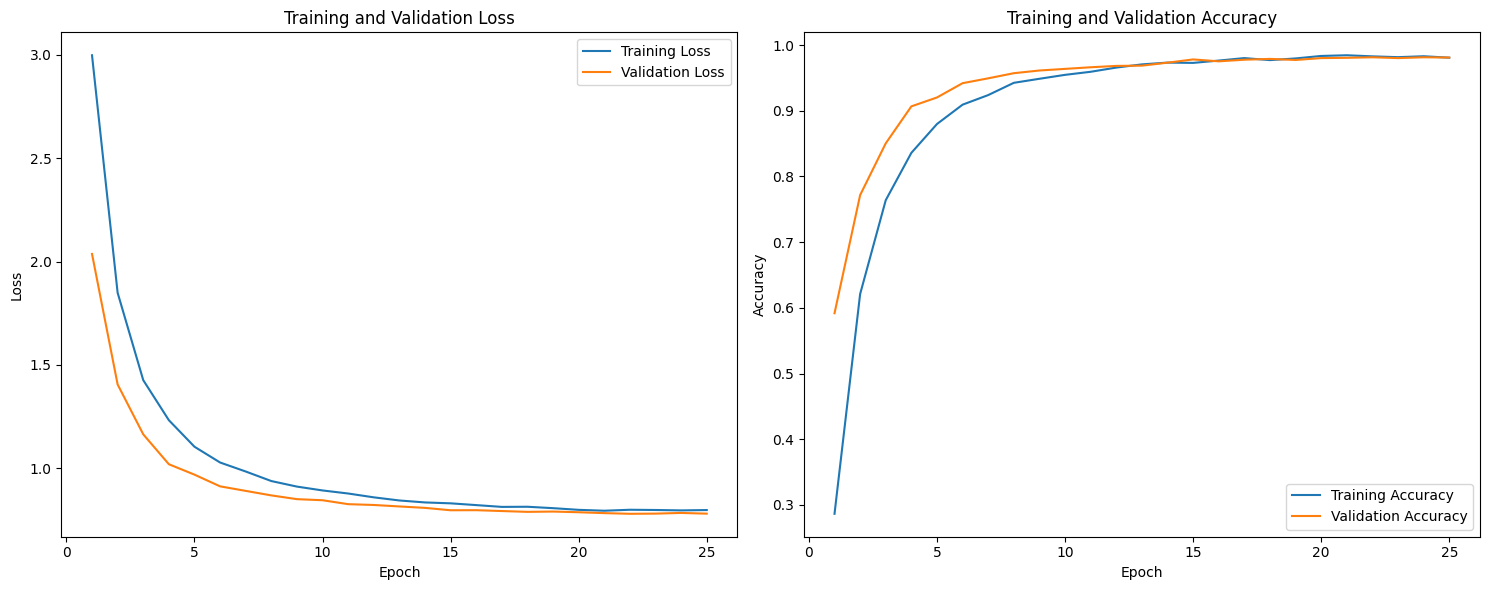

In [7]:
# ==============================================================================
# CELL 7: PLOT TRAINING HISTORY
# ==============================================================================
plt.figure(figsize=(15, 6))
epochs_range = range(1, EPOCHS + 1)

plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Training Loss')
plt.plot(epochs_range, val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label='Training Accuracy')
plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


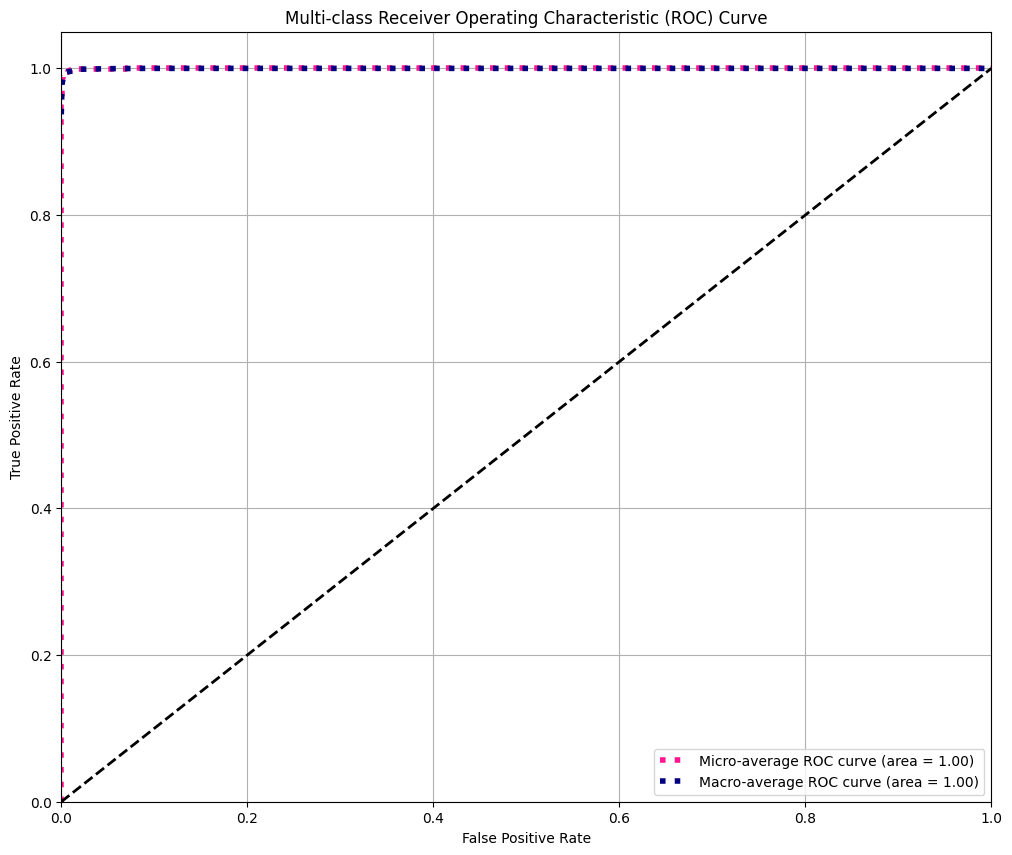

In [8]:
# ==============================================================================
# CELL 8: GET PREDICTIONS AND PLOT AUC/ROC CURVE
# ==============================================================================

@torch.no_grad()
def get_predictions_and_labels(model, loader):
    """Function to get model predictions and true labels."""
    model.eval()
    all_preds = []
    all_labels = []
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        # Apply softmax to get probabilities
        probabilities = torch.nn.functional.softmax(logits, dim=1)
        all_preds.append(probabilities.cpu().numpy())
        all_labels.append(y.cpu().numpy())
    return np.vstack(all_preds), np.concatenate(all_labels)

# --- Get Predictions ---
y_pred_probs, y_true = get_predictions_and_labels(model, test_loader)
n_classes = len(class_names)

# --- Binarize the labels for multiclass ROC ---
y_true_binarized = label_binarize(y_true, classes=range(n_classes))

# --- Compute ROC curve and ROC area for each class ---
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# --- Compute micro-average ROC curve and ROC area ---
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_binarized.ravel(), y_pred_probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# --- Compute macro-average ROC curve and ROC area ---
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
# Finally average it and compute AUC
mean_tpr /= n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# --- Plot all ROC curves ---
plt.figure(figsize=(12, 10))

# Plot Micro-average ROC
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC curve (area = {roc_auc["micro"]:0.2f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot Macro-average ROC
plt.plot(fpr["macro"], tpr["macro"],
         label=f'Macro-average ROC curve (area = {roc_auc["macro"]:0.2f})',
         color='navy', linestyle=':', linewidth=4)

# Optional: Plot ROC for a few classes if desired (plotting all 44 would be messy)
# colors = itertools.cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red'])
# for i, color in zip(range(5), colors): # Plot first 5 classes
#     plt.plot(fpr[i], tpr[i], color=color, lw=2,
#              label=f'ROC curve of class {i} (area = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2) # Plot the "no-skill" line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


Generating final report and confusion matrix on the TEST SET...

Classification Report:
                        precision    recall  f1-score   support

        Astrocitoma T1     1.0000    1.0000    1.0000        56
      Astrocitoma T1C+     0.9615    0.8929    0.9259        56
        Astrocitoma T2     0.9783    0.8036    0.8824        56
          Carcinoma T1     1.0000    0.9818    0.9908        55
        Carcinoma T1C+     1.0000    1.0000    1.0000        55
          Carcinoma T2     1.0000    1.0000    1.0000        55
         Ependimoma T1     0.9649    1.0000    0.9821        55
       Ependimoma T1C+     0.9815    0.9636    0.9725        55
         Ependimoma T2     0.9649    1.0000    0.9821        55
      Ganglioglioma T1     1.0000    1.0000    1.0000        56
    Ganglioglioma T1C+     1.0000    1.0000    1.0000        55
      Ganglioglioma T2     0.9649    0.9821    0.9735        56
          Germinoma T1     1.0000    1.0000    1.0000        55
        Germin

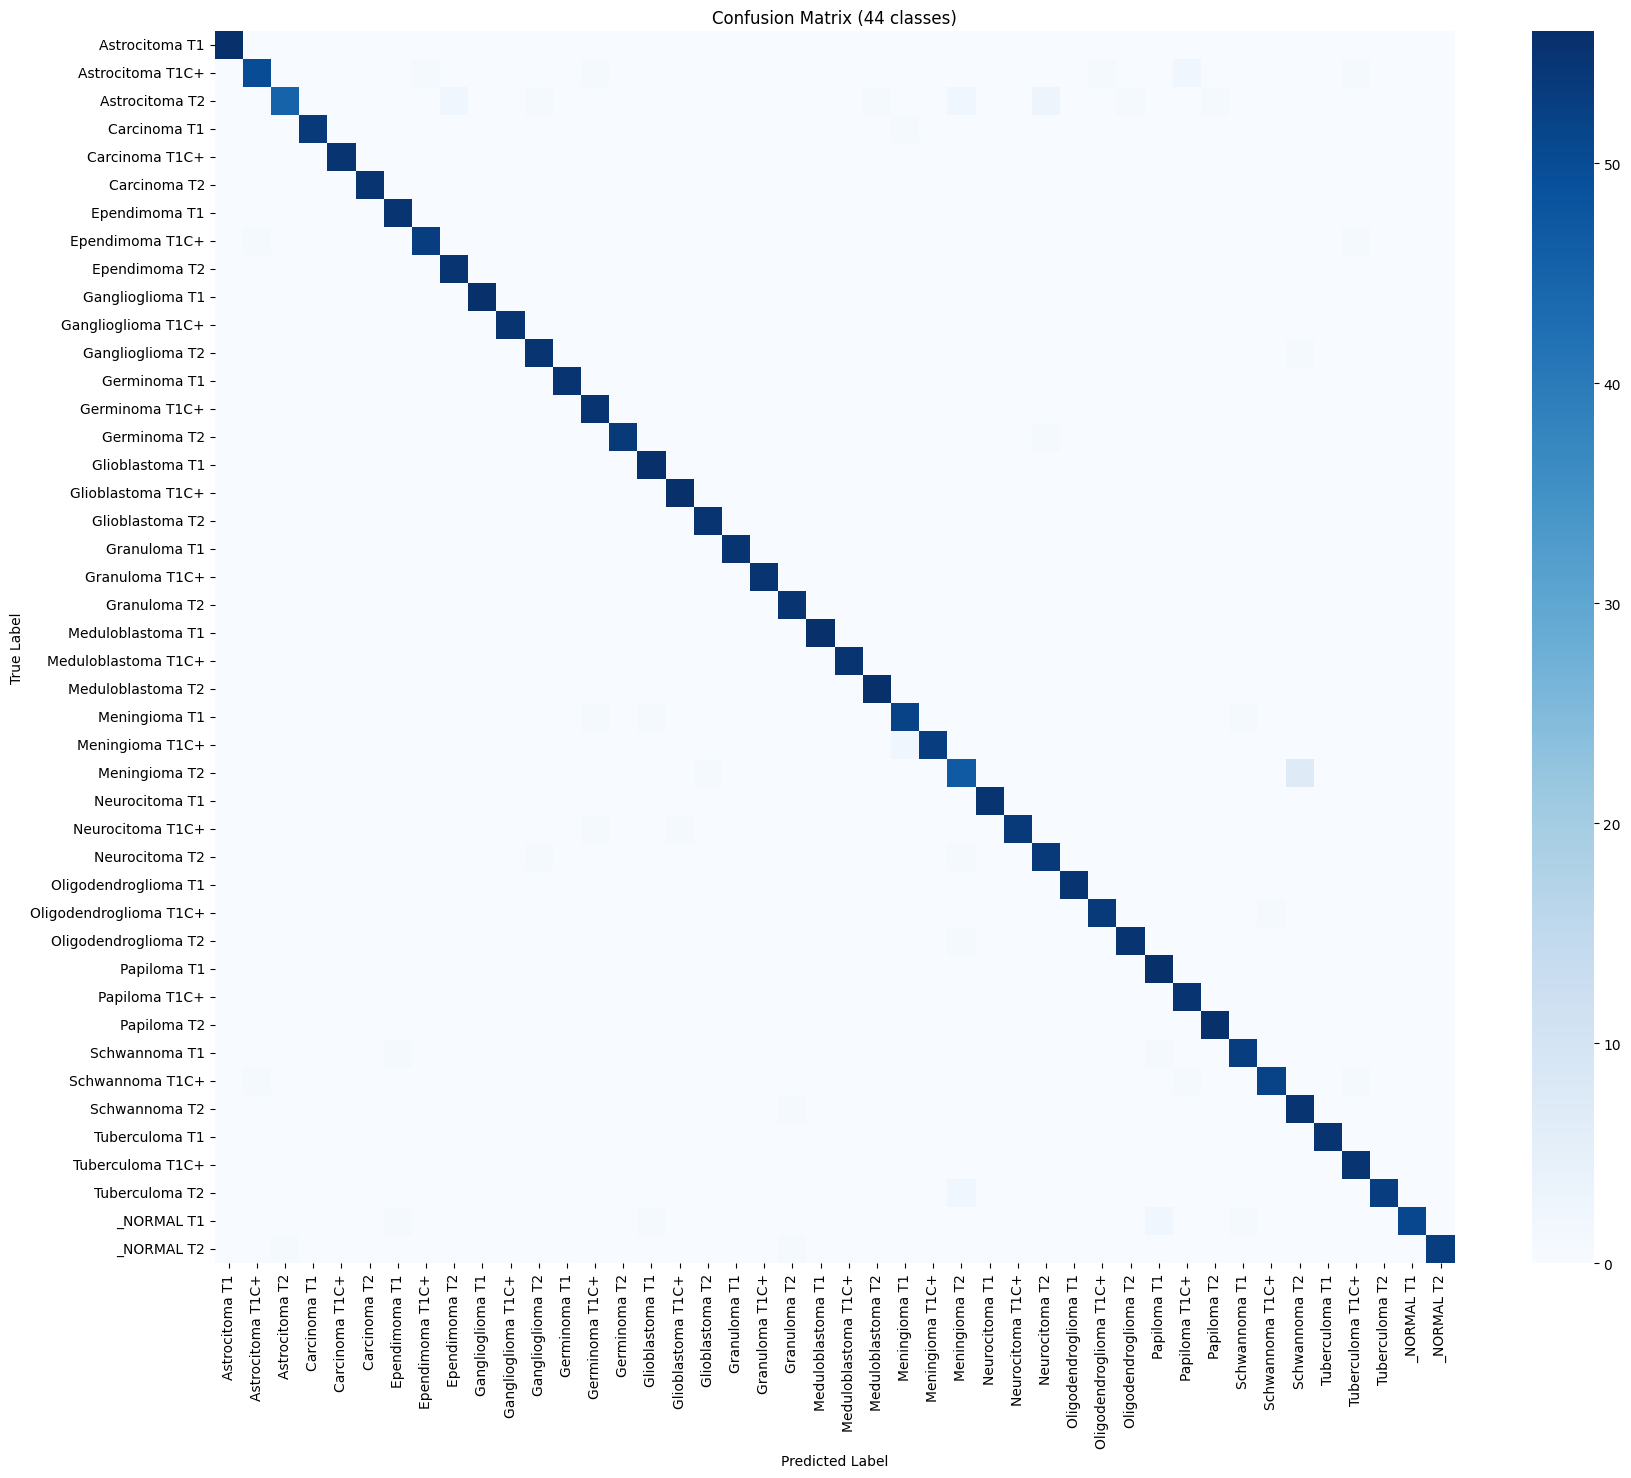

In [9]:
# ==============================================================================
# CELL 9: DETAILED REPORT AND CONFUSION MATRIX ON TEST SET
# ==============================================================================
print("\nGenerating final report and confusion matrix on the TEST SET...")
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=test_ds.classes, digits=4))

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(20, 16))
sns.heatmap(cm, annot=False, cmap="Blues", xticklabels=test_ds.classes, yticklabels=test_ds.classes)
plt.title(f"Confusion Matrix ({len(test_ds.classes)} classes)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

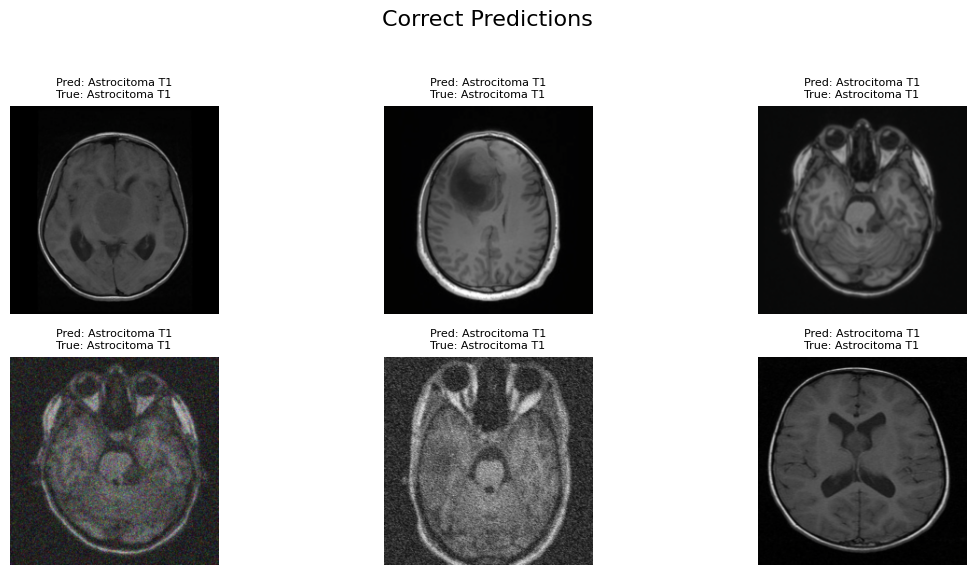

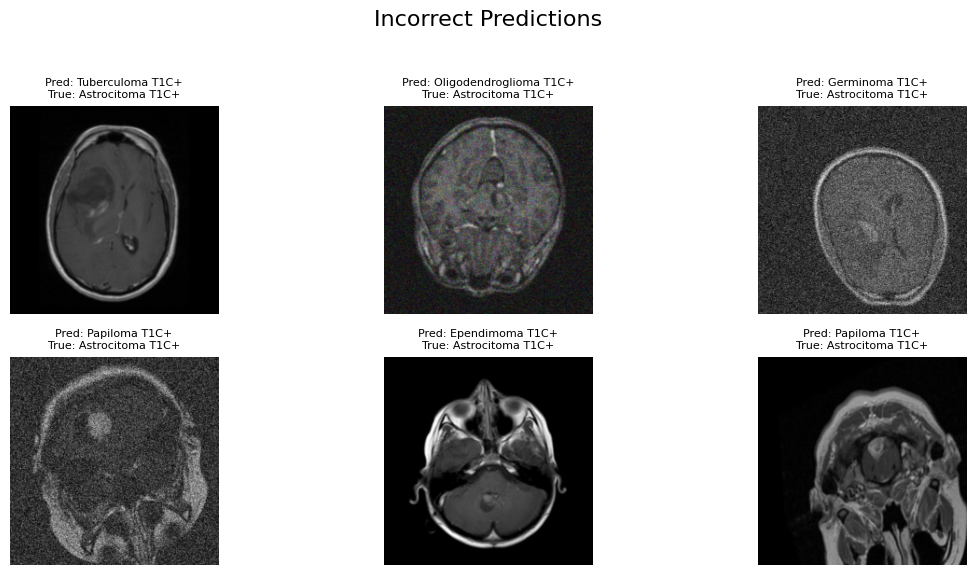

In [10]:
# ==============================================================================
# CELL 10: QUALITATIVE ANALYSIS (ERROR VISUALIZATION)
# ==============================================================================
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean, std = np.array([0.485, 0.456, 0.406]), np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title, fontsize=8)
    plt.axis('off')

correct_samples, incorrect_samples = [], []
num_to_show = 6

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images.to(device))
        _, preds = torch.max(outputs, 1)
        for i in range(images.size(0)):
            if len(correct_samples) < num_to_show and preds[i] == labels[i].to(device):
                correct_samples.append({'image': images[i], 'pred': preds[i].item(), 'true': labels[i].item()})
            elif len(incorrect_samples) < num_to_show and preds[i] != labels[i].to(device):
                incorrect_samples.append({'image': images[i], 'pred': preds[i].item(), 'true': labels[i].item()})
        if len(correct_samples) >= num_to_show and len(incorrect_samples) >= num_to_show:
            break

# --- Plot Correct Predictions ---
fig = plt.figure(figsize=(12, 6))
plt.suptitle("Correct Predictions", fontsize=16)
for i, sample in enumerate(correct_samples):
    ax = plt.subplot(2, 3, i + 1)
    title = f"Pred: {test_ds.classes[sample['pred']]}\nTrue: {test_ds.classes[sample['true']]}"
    imshow(sample['image'], title=title)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# --- Plot Incorrect Predictions ---
fig = plt.figure(figsize=(12, 6))
plt.suptitle("Incorrect Predictions", fontsize=16)
for i, sample in enumerate(incorrect_samples):
    ax = plt.subplot(2, 3, i + 1)
    title = f"Pred: {test_ds.classes[sample['pred']]}\nTrue: {test_ds.classes[sample['true']]}"
    imshow(sample['image'], title=title)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [11]:
# ==============================================================================
# CELL 11: IMPLEMENT GRAD-CAM
# ==============================================================================
import torch.nn.functional as F

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        target_layer.register_forward_hook(self.save_activation)
        target_layer.register_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activations = output

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def __call__(self, x, class_idx=None):
        self.model.zero_grad()
        output = self.model(x)

        if class_idx is None:
            # Get the index of the max logit
            class_idx = output.argmax(dim=1).item()

        # Backward pass for the selected class
        one_hot = torch.zeros_like(output).to(x.device)
        one_hot[:, class_idx] = 1
        output.backward(gradient=one_hot, retain_graph=True)

        # Get the gradients and activations
        gradients = self.gradients
        activations = self.activations

        # Global average pooling of gradients
        weights = torch.mean(gradients, dim=(2, 3), keepdim=True)

        # Compute Grad-CAM
        cam = torch.sum(weights * activations, dim=1, keepdim=True)
        cam = F.relu(cam) # Apply ReLU

        # Resize CAM to the input image size
        cam = F.interpolate(cam, size=x.shape[2:], mode='bilinear', align_corners=False)

        # Normalize CAM
        cam = cam - cam.min()
        cam = cam / (cam.max() + 1e-8)

        return cam, class_idx

print("GradCAM class defined.")

GradCAM class defined.


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


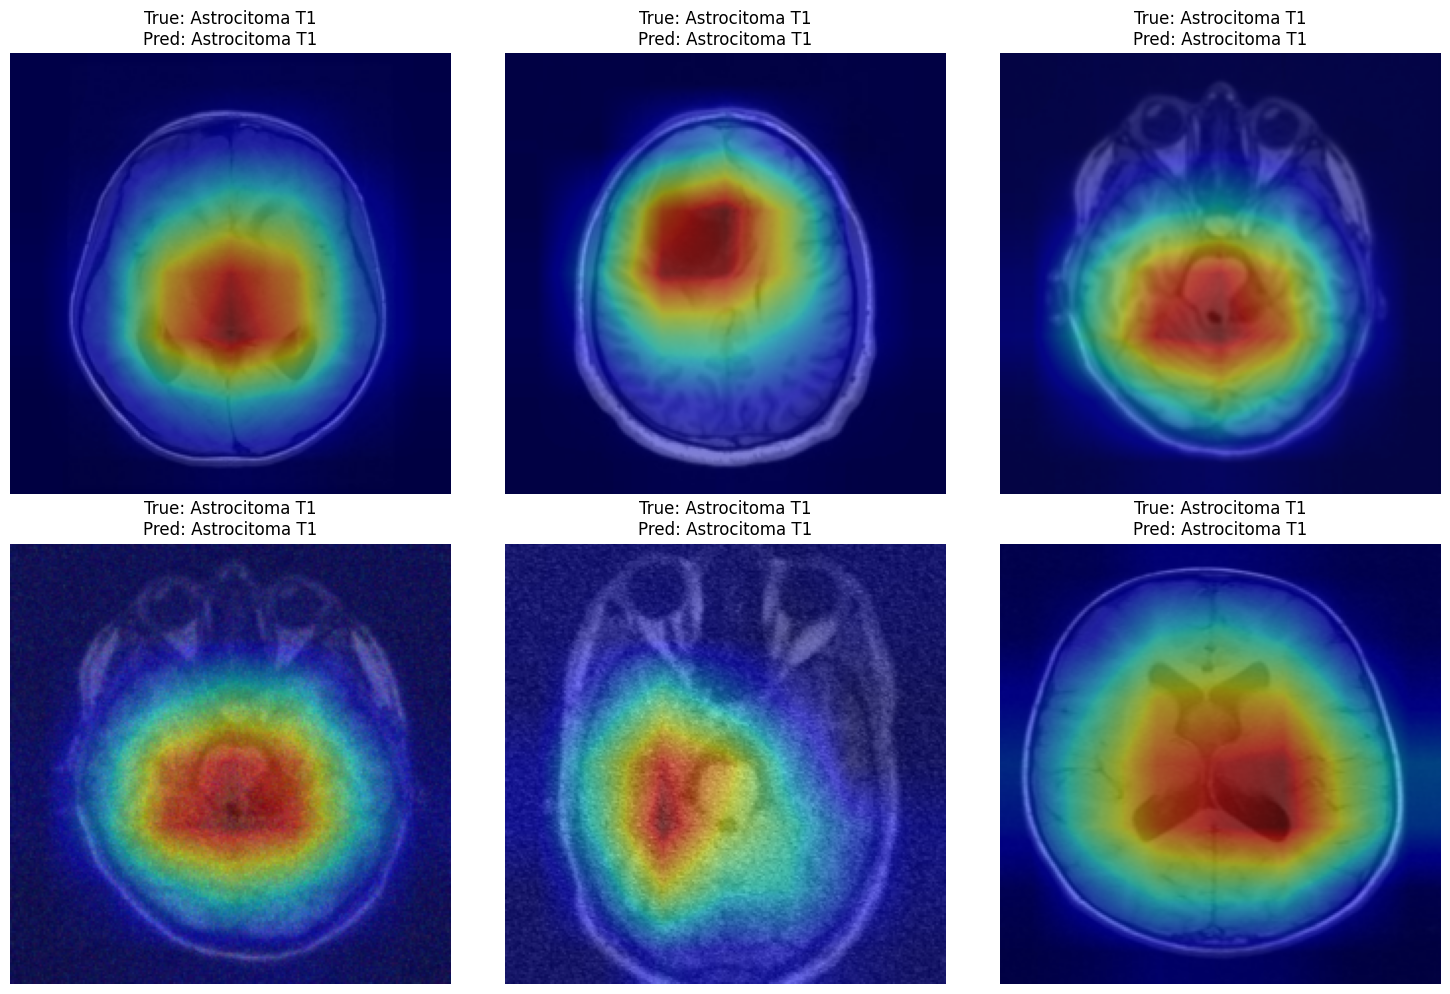

Grad-CAM visualization complete.


In [12]:
# ==============================================================================
# CELL 12: VISUALIZE GRAD-CAM
# ==============================================================================
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torchvision.transforms.functional as TF

def visualize_cam(image, cam, title=None):
    """Visualizes the Grad-CAM heatmap on the image."""
    image = TF.to_pil_image(image.squeeze(0).cpu())
    cam = TF.to_pil_image(cam.squeeze(0).cpu())

    # Resize CAM to image size and convert to heatmap
    cam = cam.resize(image.size, Image.BILINEAR)
    cam = np.array(cam)
    heatmap = plt.cm.jet(cam)[:,:,:3] * 255
    heatmap = Image.fromarray(heatmap.astype('uint8'))

    # Blend image and heatmap
    blended_image = Image.blend(image.convert('RGB'), heatmap.convert('RGB'), alpha=0.5)

    plt.imshow(blended_image)
    plt.axis('off')
    if title:
        plt.title(title)

# --- Get a batch of images from the test set ---
images, labels = next(iter(test_loader))
images = images.to(device)

# --- Select the target layer for Grad-CAM ---
# For EfficientNetB0, a good target layer is typically the last convolutional layer before the classifier.
# This might vary slightly depending on the exact model implementation.
# Let's try the last block's last convolutional layer.
# Looking at the EfficientNetB0 structure, a potential target could be the last layer of the last block,
# for example, model.efficientnet.features[-1][0]._conv or model.efficientnet.features[-1][-1]._conv
# Let's try model.efficientnet.features[-1][-1]
target_layer = model.efficientnet.features[-1][-1]


# --- Initialize Grad-CAM ---
grad_cam = GradCAM(model, target_layer)

# --- Visualize Grad-CAM for a few images ---
num_images_to_show = 6
plt.figure(figsize=(15, 10))

for i in range(min(num_images_to_show, images.size(0))):
    img = images[i].unsqueeze(0) # Add batch dimension
    label = labels[i].item()

    cam, predicted_class_idx = grad_cam(img)

    plt.subplot(2, 3, i + 1)
    true_class_name = test_ds.classes[label]
    predicted_class_name = test_ds.classes[predicted_class_idx]
    title = f"True: {true_class_name}\nPred: {predicted_class_name}"

    # Denormalize image for visualization
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img_denormalized = img.squeeze(0).cpu().numpy().transpose((1, 2, 0))
    img_denormalized = std * img_denormalized + mean
    img_denormalized = np.clip(img_denormalized, 0, 1)
    img_denormalized = torch.from_numpy(img_denormalized.transpose((2, 0, 1)))


    visualize_cam(img_denormalized, cam, title=title)

plt.tight_layout()
plt.show()

print("Grad-CAM visualization complete.")